Generative Adversarial Network trained on MNIST dataset

Code by [Anonymised for essay requirements], modified from code by Rowel Atienza

First import the libraries

In [ ]:
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pickle

We define a datalogger in order to store and import the loss and accuracy of the GAN over the course of the training.

In [2]:
class DataLog():
    #This object logs the performance of the GAN
    def __init__(self):
        self.D_acc=[]
        self.G_acc=[]
        self.D_loss=[]
        self.G_loss=[]
    def log(self, data):
        self.D_acc.append(data[0])
        self.G_acc.append(data[1])
        self.D_loss.append(data[2])
        self.G_loss.append(data[3])
    def save(self, filename=False):
        try:
            if not filename:
                filename = "MNIST-Logdata-{}-Epochs".format(len(self.D_acc))
            savedfile = open(filename,'wb') 
            data=[self.D_acc,self.G_acc,self.D_loss,self.G_loss]
            pickle.dump(data,savedfile)  
            savedfile.close()
            print("Saved log files to {}".format(filename))
        except:
            print("log file load failed")
    def load(self, filename):
        loadfile = open(filename,'rb') 
        data = pickle.load(loadfile)  
        self.D_acc=data[0]
        self.G_acc=data[1]
        self.D_loss=data[2]
        self.G_loss=data[3]
        print("Loaded log files from {}".format(filename))

We also define a timer to see how long training takes.

In [3]:
class Timer():
    #This object tracks the timing of the GAN
    def __init__(self):
        self.reset()
    def reset(self):
        self.start_time = time.time()
    def elapsed(self,l_time):
        output = ""
        if l_time >= 3600:
            hours = int(math.floor(l_time / (60 * 60)))
            l_time -= hours*60*60
            output += "{} hr ".format(hours)
        if l_time >=60:
            minuites = int(math.floor(l_time / (60)))
            l_time -= minuites*60
            output += "{} min ".format(minuites)
        return output+ "{0:.2f} sec ".format(l_time) 
    def elapsed_time(self):
        print("Time Elapsed: {}".format(self.elapsed(time.time() - self.start_time)))

Here we define the GAN object, which includes the generator, disciminator and the optimisation rules.

Furthermore, we define a function to print images of the data.

In [4]:
class DCGAN(object):
    '''This object defines our GAN'''
    def __init__(self):
        #Initialise objects to keep track of log data
        self.logdata = DataLog()
        self.timer= Timer()
        
        #Some variables regarding the input size
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        self.epochs = 0
        
        #Load the training data
        self.x_train = input_data.read_data_sets("mnist",one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)
        
        #Initalise the Generator and Discriminator
        self.G = None
        self.D = None
        self.DM = None
        self.AM= None
        
        self.discriminator =  self.discriminator_model()
        self.adversarial = self.adversarial_model()
        self.generator = self.init_generator()
        

    def saveweights(self,genfile=False,disfile=False):
        #Save the weights of the GAN for later use
        if not genfile:
            genfile="generator_{}.h5".format(len(self.logdata.D_acc))
        if not disfile:
            disfile = "discriminator_{}.h5".format(len(self.logdata.D_acc))
        self.G.save(genfile)
        self.D.save(disfile)
        print("Saved generator weights to {}".format(genfile))
        print("Saved discriminator weights to {}".format(disfile))
        

    def loadweights(self,genfile="generator_5000.h5",disfile="discriminator_5000.h5", logfile ="MNIST-Logdata-5000-Epochs"):
        #This function loads the weights of a previously trained GAN. 
        #The default inputs for this function are weights have been trained for 5000 epochs. 
        try:
            self.G.load_weights(genfile)
            print("Loaded generator weights from {}".format(genfile))
        except:
            print("Loading generator weights failed")
        try:
            self.D.load_weights(disfile)
            print("Loaded discriminator weights from {}".format(disfile))
        except:
            print("Loading discriminator weights failed")
        self.logdata.load("MNIST-Logdata-5000-Epochs")
        self.epochs = len(self.logdata.D_acc)
        
        

    def train(self, train_steps=1000, batch_size=256):
        #Trains the GAN
        #Start timer
        self.timer.reset()
        for i in range(train_steps):
            #increment counter for number of epochs elapsed
            self.epochs+=1
            
            #Sample Real Data
            images_train = self.x_train[np.random.randint(0,self.x_train.shape[0], size=batch_size), :, :, :]
            
            #Sample Fake Data
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            
            #Create Discriminator Dataset
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            #Train Discriminator 
            d_loss = self.discriminator.train_on_batch(x, y)
            
            #Create Generator Data       
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            #Choose labels to be 1. 
            #Plugging this into the cross entropy mean the objective for the generator maximises Log(D(G(x)))
            #This is the heuristic game which gives us better gradients early in training
            y = np.ones([batch_size, 1])
            
            #Train the Generator
            a_loss = self.adversarial.train_on_batch(noise, y)
            
            #Print the Log Messages
            log_mesg = "%d: [D loss: %f, acc: %f]" % (self.epochs, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            
            #Save to the log file
            self.logdata.log([d_loss[1],a_loss[1],d_loss[0],a_loss[0]])
        #Log the time
        self.timer.elapsed_time()
    
    def init_discriminator(self):
        #Defines the discriminator -- this is a convolutional neural network which tries to see if the image is real
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        
        input_shape = (28,28, 1)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Flatten())
        self.D.add(Dense(1))
        #Sigmoid output ensures that the output is a probability
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D
    
    def init_generator(self):
        #Defines the discriminator -- this is a deconvolutional neural network which generates images from a prior
        #The prior is a random vector with components uniformly distributed on [-1,1]
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7

        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))


        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Output is 28 x 28 x 1 grayscale image [0.0,1.0] per pixel
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G


    def discriminator_model(self):
        #Defines the optimiser objective for the discriminator
        #We use the adam gradient method for both networks
        optimizer =  Adam(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.init_discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        #Defines the objective for the generator
        #We use the adam gradient method for both networks
        optimizer =  Adam(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.init_generator())
        self.AM.add(self.init_discriminator())
        #Note that we nest the generator and dicriminator -- this means the objective is defined in terms of the discriminator
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM
    
    
    def plot_images(self, fake=True, samples=16, noise=None, step=0, dim=[4,4], size = (10, 10)):
        #This function allows us to plot images
        if fake:
            #Draws pictures from the generator
            #sample random images if the noise input is left blank
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            images = self.generator.predict(noise)
        else:
            #Draws pictures from the training data for comparison
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]
        
        #draws the pictures
        plt.figure(figsize=size)
        for i in range(images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    
        

We call our GAN object. Here we can see the number of parameters in each layer of the the generator and disciminator.

In [5]:
mnist_dcgan = DCGAN()

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None

Call this to load a model which has already been trained for 5000 epochs.

In [6]:
mnist_dcgan.loadweights()

Loaded generator weights from generator_5000.h5
Loaded discriminator weights from discriminator_5000.h5
Loaded log files from MNIST-Logdata-5000-Epochs


We call this function to have a look at some of the outputs.

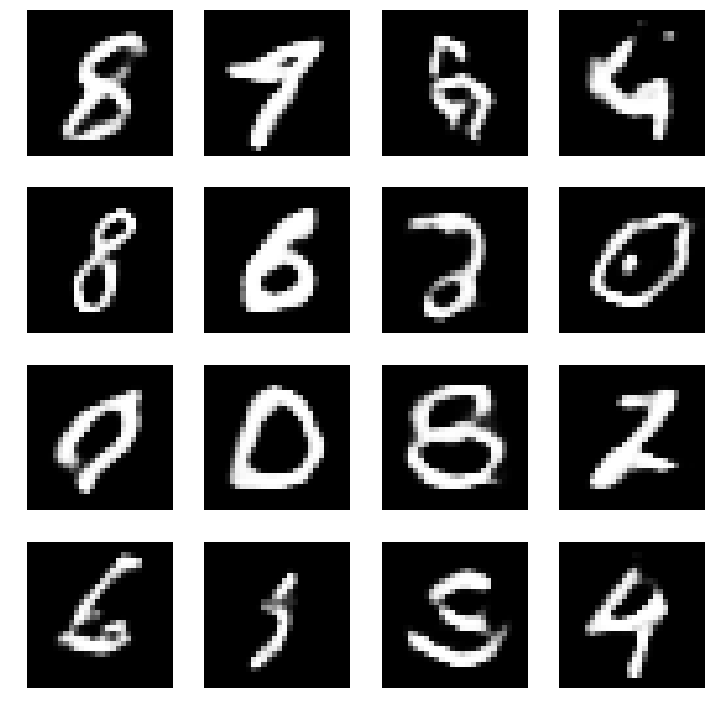

In [24]:
mnist_dcgan.plot_images(fake=True,  dim=[4,4], size = (10, 10))

Plot the accuracy of the discriminator:

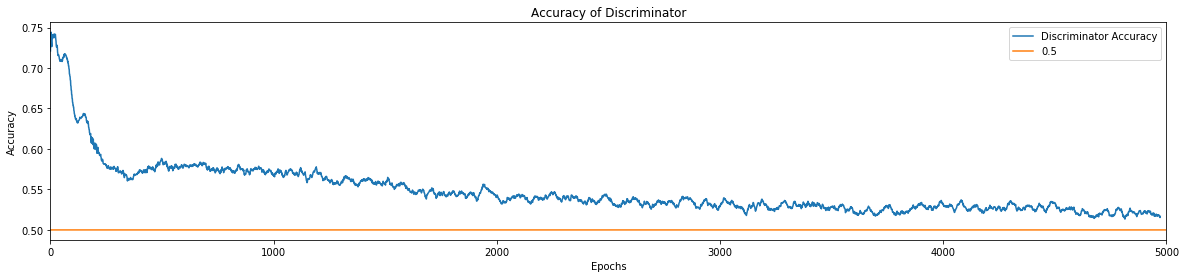

In [8]:
import matplotlib.pyplot as plt
def movav (arr, l):
    out = [sum(arr[:l])/l]
    for i in range (len(arr) -l):
        out.append(out[-1]+arr[i+l]/l-arr[i]/l)
    return out

plt.figure(figsize=(20, 4))
p1,=plt.plot(movav(mnist_dcgan.logdata.D_acc[:],30), label="Discriminator Accuracy")
p2,=plt.plot([0.5]*mnist_dcgan.epochs, label="0.5")
plt.xlim(0,5000)
plt.legend(handles=[p1, p2])

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy of Discriminator')
plt.show()

Plot the losses of the generator and the discriminator:

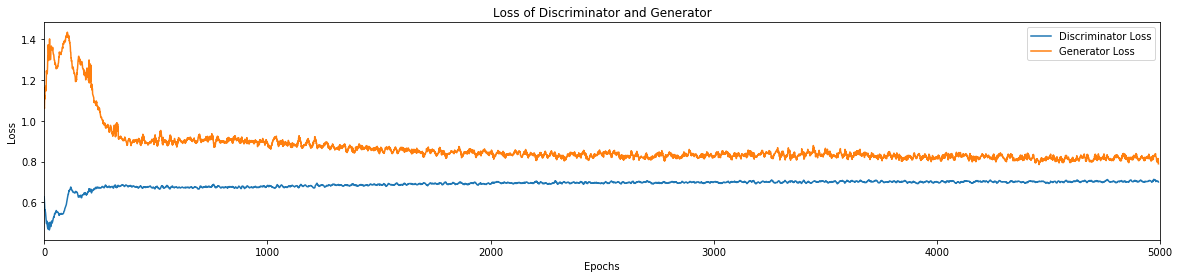

In [9]:
plt.figure(figsize=(20, 4))
p1,=plt.plot(movav(mnist_dcgan.logdata.D_loss[:],10), label="Discriminator Loss")
p2,=plt.plot(movav(mnist_dcgan.logdata.G_loss[:],10), label="Generator Loss")
plt.xlim(0,5000)
plt.legend(handles=[p1, p2])

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss of Discriminator and Generator')
plt.show()

Prints plot which interpolates between two data points.

This is a test to see if the GAN has simply memorised the training data.

If there is good variation in between the two points, then it suggests that the GAN has learned a lot more images than just the training data.


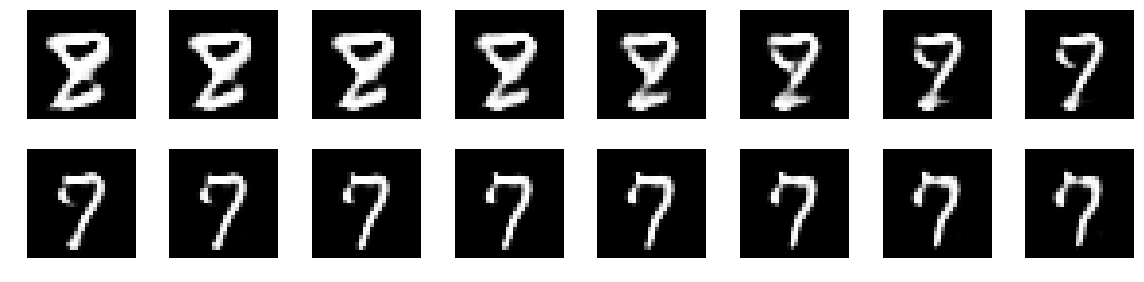

In [21]:
#Generates two random samples
p0=np.random.uniform(-1.0, 1.0, size=[100])
p1=np.random.uniform(-1.0, 1.0, size=[100])
def plot_interpolation(d1, d2):
    #Interpolates between the images
    dif = (d2-d1)/15
    interp = np.asarray([p0 + i* dif for i in range (16)])
    mnist_dcgan.plot_images(fake=True, noise = interp, dim=[2,8], size = (16, 4))
plot_interpolation(p0, p1)

This function takes some data from the training set and samples a large number of images from the generated distribution.

It then tries to find the closest sampled data to the training data. This is another test to ensure that the GAN has not simply memorised the input data.

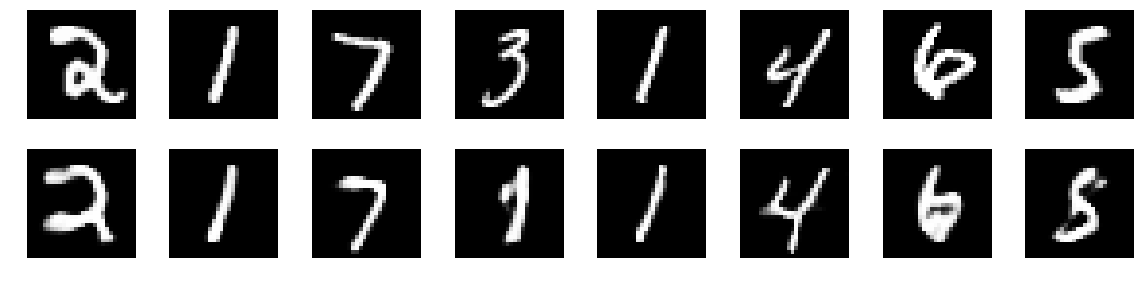

In [11]:
def plot_closest(fake=True, samples=10000, step=0, dim=[2,8], size = (16, 4)):
    def dist(a,b):
        #Defines Euclidean Distance between images
        x=np.asarray(a.flatten())
        y=np.asarray(b.flatten())
        return sum((x-y)**2)
    
    #generate large number of random samples
    noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
    genimages = mnist_dcgan.generator.predict(noise)
    
    #pick 8 random training data points
    i = np.random.randint(0, mnist_dcgan.x_train.shape[0], 8)
    images = mnist_dcgan.x_train[i, :, :, :]
    
    #find closest points to the trianing data within the sampled data
    closest = []
    for img in images:
        mindist = dist(img, genimages[0])
        currmin = genimages[0]
        for genimage in genimages:
            d=dist(img, genimage)
            if d<mindist:
                mindist=d
                currmin = genimage
        closest.append(currmin)
        
    #draw the images
    images=np.concatenate((images, closest),axis=0)
    plt.figure(figsize=size)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [28,28])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
plot_closest(fake=True, samples = 2000)


Call this to train the model further:

In [ ]:
steps=1000
mnist_dcgan.train(train_steps=steps, batch_size=256)